In [1]:
import matplotlib.pyplot as plt
import numpy as np

from testcases import TestCase

from domains import Waveguide, ScattererShape, ScattererType

# First Experiment (H convergence)

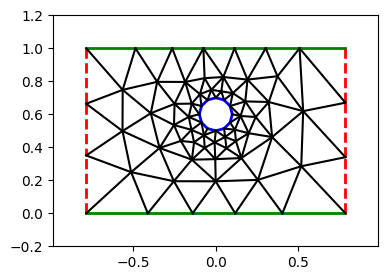

In [2]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.

Domain = Waveguide(R=R,H=H)
Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, ((0,0.6*H), 0.1*H))
Domain.generate_mesh(h_max=H)
Domain.plot_mesh()

In [9]:
from Trefft_tools import  TrefftzSpace
Nth = 5
th_0 = np.e/np.pi # no correct direction in the basis
#th = 0. # right direction in the basis
V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )


In [10]:
from Trefft_tools import AssembleMatrix
N_modes = 20 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Domain.Edges, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

580 degrees of freedom.
 Matrix with 11150 non-zero entries from a total of 336400.
 "fullness" ratio:  3.31%


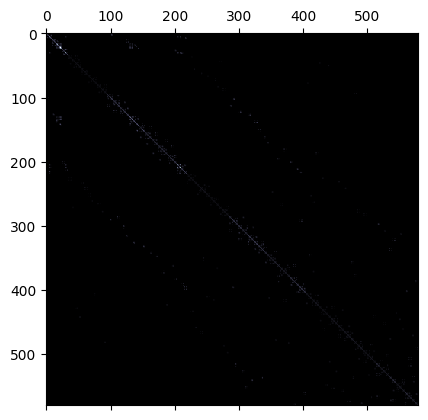

In [11]:
from checking_tools import plot_sparsity
plot_sparsity(A)

In [12]:
Ncond = np.linalg.cond(A.toarray())
Ncond

40858.50203887157

In [13]:
from Trefft_tools import AssembleGreenRHS